# Predictive Maintenance of a Water Pump

**Aim:** Given the sensor data, predict water pump failure in advance to guide timely maintenance scheduling. 

**Methodology:** Use an LSTM neural network (a type of RNN) to predict when a failure might happen based on time series data.

**Dataset:** [pump_sensor_data](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data/metadata)

### Setup
Import the necessary libraries.

In [153]:
import pandas as pd
import numpy as np
import matplotlib
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras import models

In [154]:
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Tensorflow version: {}'.format(tensorflow.__version__))

Pandas version: 1.4.2
Numpy version: 1.22.3
Matplotlib version: 3.5.1
Tensorflow version: 2.4.1


### Get Data

Load the pump sensor data.

In [3]:
# parse timestamp column as datetime object upon reading the data
df_raw_data = pd.read_csv('data/sensor.csv', parse_dates=['timestamp'], index_col=0)

In [ ]:
# specify the target feature as a categorical data type
df_raw_data['machine_status'] = pd.Categorical(df_raw_data['machine_status'], 
                                                categories=['BROKEN', 'NORMAL', 'RECOVERING'],
                                                ordered=True)

## Data Exploration

In [4]:
# initial look at the features
df_raw_data.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [5]:
# determine the size of the dataset
print('The dataset has the following shape: {}'.format(df_raw_data.shape))

The dataset has the following shape: (220320, 54)


To sum up, there are 52 sensors with a measurement made every minute for 220320 minutes (153 days). The `machine_status` column is the target feature that will be used to predict maintenance and will be explored next. 

In [6]:
# investigate the number of features for each target feature
df_raw_data.groupby('machine_status')['machine_status'].count()

machine_status
BROKEN             7
NORMAL        205836
RECOVERING     14477
Name: machine_status, dtype: int64

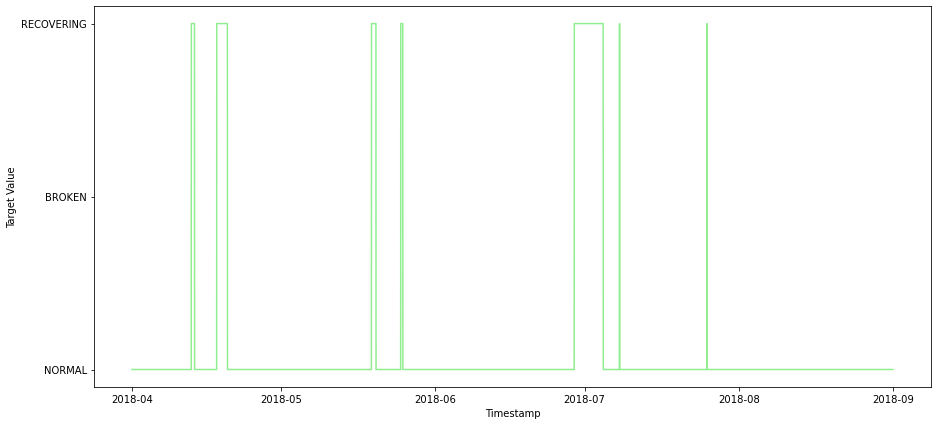

In [21]:
# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
ax.plot(df_raw_data['timestamp'],
        df_raw_data['machine_status'],
        color='lightgreen')

# set title and labels
ax.set(ylabel = 'Target Value',
    xlabel = 'Timestamp')

plt.show()

Among the ~220k instances only 7 indicate when the machine has been broken. With only seven instances it is impossible to train an ML model in a meaningful way. However, from the plot above, it is evident that 'BROKEN' events are always clustered together with the 'RECOVERING' events that could be used as a proxy to predict when a machine has been broken. 

Despite there being substantially more 'RECOVERING' events compared to 'BROKEN' events, they still constitute only ~6.5% of total instances. The imbalance in the dataset will be an important fact to consider when evaluating the performance of the model later on.

## Data Cleaning 

At this stage, the completeness of the dataset is considered and the following questions asked:
- How many NaN values are there?
- Are NaN values clustered around certain features (columns) or instances (rows)?
- Can the missing values be filled in or have to be removed altogether?

In [34]:
# check if there are Null values in the dataset
print('Number of Null values in the dataset: {}'.format(df_raw_data.isnull().sum().sum()))


Number of Null values in the dataset: 344574


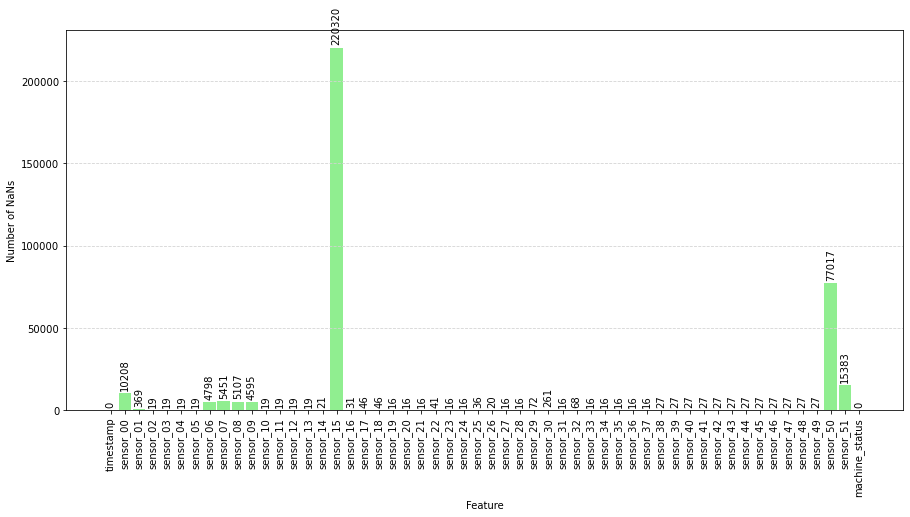

In [58]:
# find the number of NaNs for each feature 
count_nans = df_raw_data.isnull().sum().to_frame('count_nans')

# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
bar = ax.bar(count_nans.index,
        count_nans['count_nans'],
        width=0.9,
        color='lightgreen')

# set title and labels
ax.set(ylabel = 'Number of NaNs',
    xlabel = 'Feature')

# rotate the x axis labels for better readability 
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.bar_label(bar, padding=3, rotation=90)

plt.grid(color='lightgray', linestyle='--', axis='y')
plt.show()

From bar chart above it is evident that `sensor_15` is missing all value and will need to be removed. Other sensors with a large number of missing values include `sensor_00`, `sensor_50` and `sensor_51` and need to be investigated in more detail. 

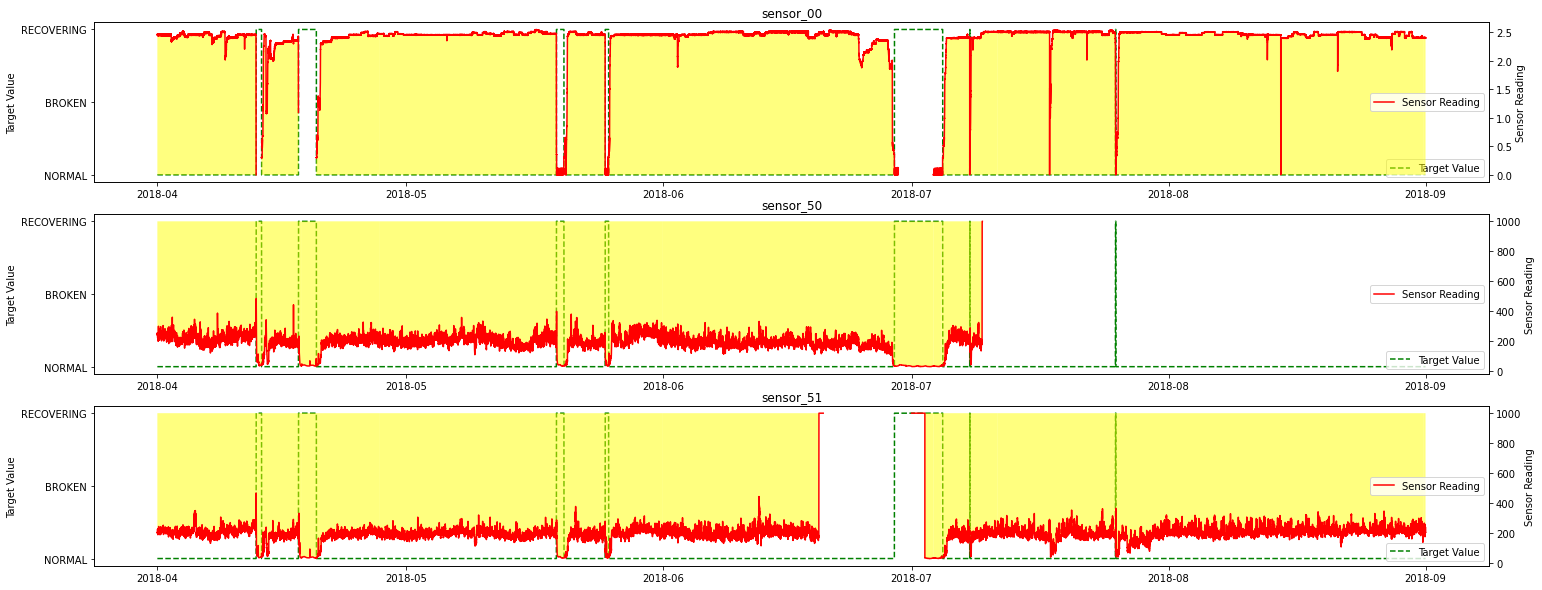

In [109]:
# create a figure
fig, ax = plt.subplots(3,1,figsize=(25, 10))
# sensors to be plotted
axes = ['sensor_00', 'sensor_50', 'sensor_51']

for i, a in enumerate(axes):

        # add data to axis
        ax[i].plot(df_raw_data['timestamp'],
                df_raw_data['machine_status'],
                color='green',
                linestyle='--')

        # create the second y axis
        ax02 = ax[i].twinx()
        # add data to the second axis
        ax02.plot(df_raw_data['timestamp'],
                df_raw_data[a],
                color='red')
        ax[i].set(ylabel= 'Target Value', title=a)
        ax02.set(ylabel = 'Sensor Reading')

        # Code by Mr.T from StackOverflow: https://stackoverflow.com/questions/66483363/highlight-data-gaps-nan-in-matplotlib-scatter-plot
        # fill in the area above/below the graph to highlight the gaps in the data
        if i == 0:
                ax02.fill_between(df_raw_data['timestamp'], df_raw_data[a], df_raw_data[a].min(), where=np.isfinite(df_raw_data[a]), facecolor="yellow", alpha=0.5)
        else:
                 ax02.fill_between(df_raw_data['timestamp'], df_raw_data[a], df_raw_data[a].max(), where=np.isfinite(df_raw_data[a]), facecolor="yellow", alpha=0.5)

        ax02.legend(['Sensor Reading'], loc='center right')
        ax[i].legend(['Target Value'], loc='lower right')

plt.show()

From the graphs above it is evident that `sensor_50` stop producing any signal two thirds through the reading. Similarly, `sensor_51` gives out for a chunk of the time in the middle of the reading. As Jan Werth point out in [his article](https://towardsdatascience.com/lstm-for-predictive-maintenance-on-pump-sensor-data-b43486eb3210) the readings for `sensor_50` and `sensor_51` are remarkably similar and could be combined to reconstruct one of the readings.

I've decided to use the data from `sensor_51` to construct `sensor_50` (the more straight forward option). In addition, both sensors appear to give a very high reading just before/after malfunctioning, therefore I'll assume this the result of the sensor failure and not the actual state of the machine. In the process of merging the data from `sensor_50` and `sensor_51` these atypically high readings will be removed.

Similar to `sensor_51`, `sesnor_00` malfunctions for chunks of time. To further evaluate, how to deal with NaNs in `sesnor_00` and others, the variance for data readings are plotted. The reasoning being that we want to keep sensors with a high variability in their readings that might point to the malfunction.

/var/folders/n8/lyd38hsj3kl16nsbtrppwjbw0000gn/T/ipykernel_12252/2432662497.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_var = df_raw_data.var().to_frame('var')


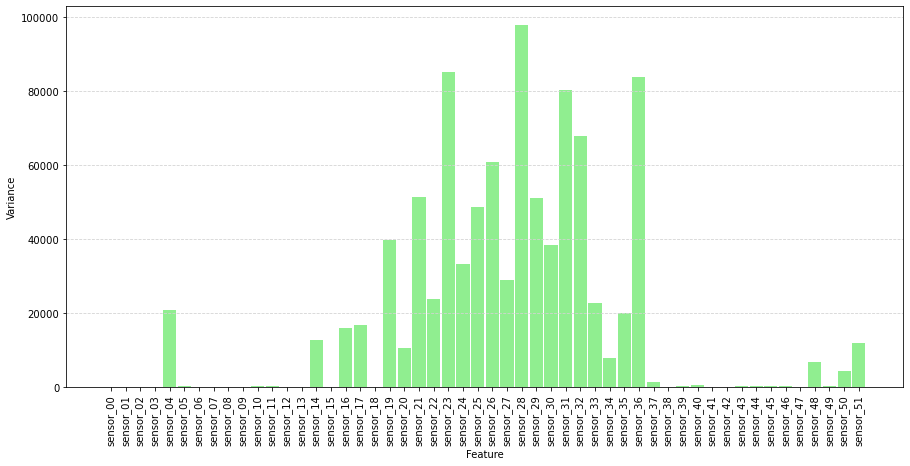

In [122]:
df_var = df_raw_data.var().to_frame('var')

# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
bar = ax.bar(df_var.index,
        df_var['var'],
        width=0.9,
        color='lightgreen')

# set title and labels
ax.set(ylabel = 'Variance',
    xlabel = 'Feature')

# rotate the x axis labels for better readability 
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

# ax.bar_label(bar, padding=3, rotation=90)

plt.grid(color='lightgray', linestyle='--', axis='y')
plt.show()

Based on the sensor variances the following features can be removed:
* from `sesnor_00` to `sensor_03` (inclusive)
* from `sesnor_05` to `sensor_13` (inclusive)
* `sensor_15`
* `sensor_18`
* from `sesnor_38` to `sensor_39` (inclusive)
* from `sesnor_41` to `sensor_47` (inclusive)
* `sensor_49`

Removing some of these sensors also solves the issue of extended gaps of NaN values. 

The remaining NaN values will be filled using `fillna()` function and `ffill` method with a limit of 30 (only fill up to 30 consecutive NaN values in the same column). The limit value is an arbitrary choice.

## Feature Engineering

Following the insights in the previous section, the necessary changes are made to the dataset. The changes are summarised below:
* Drop `sensor_15`
* Combine data from `sensor_50` and `sensor_51`
* Drop sensors with little variance (summarised above)
* Fill NaN values

In addition, data are split into training, testing and validation sets and normalised following the steps in this [Tensorflow article.](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [141]:
# drop empty features/ features with little variance
df_eng = df_raw_data.drop(columns=['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_05', 'sensor_06', 'sensor_07', 
                                    'sensor_08', 'sensor_09','sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15',
                                    'sensor_18', 'sensor_38', 'sensor_39', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 
                                    'sensor_45', 'sensor_46', 'sensor_47', 'sensor_49' ]).copy()

In [142]:
df_raw_data['sensor_50'][38498:38509]

38498    184.0278
38499    190.1042
38500    194.1551
38501    196.7593
38502    198.7847
38503    202.2569
38504    205.4398
38505    208.9120
38506    212.6736
38507    216.1458
38508         NaN
Name: sensor_50, dtype: float64

In [143]:
# combine data from sensor_50 and sensor_51 into a new feature
df_eng['sensor_50'] = df_eng.apply(lambda x: x['sensor_50'] if pd.isna(x['sensor_50']) == False else x['sensor_51'], axis=1)

In [144]:
# drop data for sensor_50 and sensor_51
df_eng = df_eng.drop(columns=['sensor_51'])

In [145]:
# fill NaN values 
df_eng = df_eng.fillna(method='ffill', limit=30)

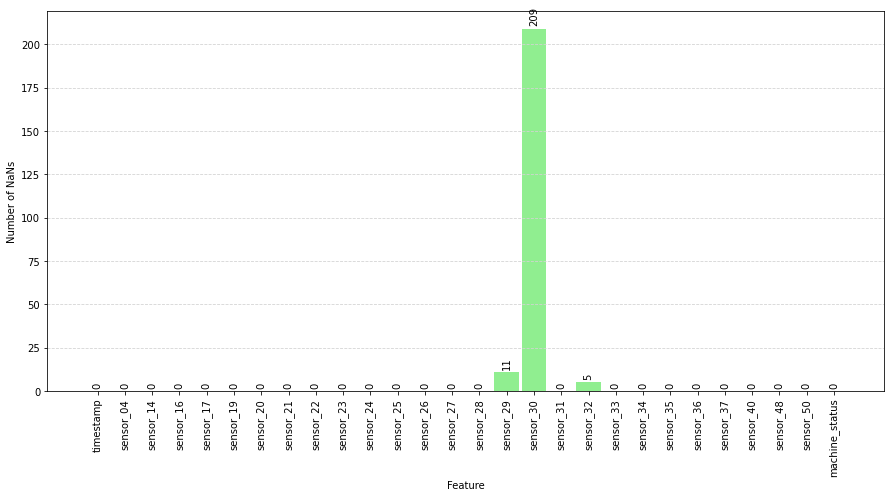

In [146]:
# plot the remaining NaN value to identify to identify how to deal with them
# find the number of NaNs for each feature 
count_nans_eng = df_eng.isnull().sum().to_frame('count_nans')

# create a figure
fig, ax = plt.subplots(figsize=(15, 7))

# add data to axis
bar = ax.bar(count_nans_eng.index,
        count_nans_eng['count_nans'],
        width=0.9,
        color='lightgreen')

# set title and labels
ax.set(ylabel = 'Number of NaNs',
    xlabel = 'Feature')

# rotate the x axis labels for better readability 
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.bar_label(bar, padding=3, rotation=90)

plt.grid(color='lightgray', linestyle='--', axis='y')
plt.show()

In [147]:
# drop the remaining NaN values
df_eng = df_eng.dropna()

Following feature engineering, data are split into training, testing and validation sets. Contrary to most datasets, this datasets is not randomly shuffled prior splitting to maintain the contextual information of time series data.

In [148]:
# Code reference: https://www.tensorflow.org/tutorials/structured_data/time_series
n = len(df_eng)
test_df = df_eng[0:int(n*0.1)]
val_df = df_eng[int(n*0.1):int(n*0.3)]
train_df = df_eng[int(n*0.3):]

During the data exploration phase it was noted that the range of sensors vary significantly (e.g., compare reading from `sensor_00` and `sensor_50`), therefore data are normalised. For each feature the values are normalised by subtracting the mean and dividing by standard deviation of each feature as follows:

    feature_norm = (feature - feature_mean) / feature_sd

In [150]:
df_mean = train_df.mean()
df_sd = train_df.std()

# test_df = (test_df - df_mean) / df_sd
# val_df = (val_df - df_mean) / df_sd
# train_df = (train_df - df_mean) / df_sd

/var/folders/n8/lyd38hsj3kl16nsbtrppwjbw0000gn/T/ipykernel_12252/1727472153.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_mean = train_df.mean()
/var/folders/n8/lyd38hsj3kl16nsbtrppwjbw0000gn/T/ipykernel_12252/1727472153.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_mean = train_df.mean()
/var/folders/n8/lyd38hsj3kl16nsbtrppwjbw0000gn/T/ipykernel_12252/1727472153.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sd = train_df.std()


## Data Prep for the LSTM